# LSTM

1. LSTMUnit
2. LSTMLayer
3. LSTM

In [37]:
# import relevant libraries
import numpy as np
import torch
import torch.nn as nn
import jax
import jax.numpy as jnp
import time
from tqdm import tqdm

**Terminologies**

* batch_size: B
* input_size: F
* hidden_size: U
* sequence_length: L

* input vector x: dimensions (B, F)
* hidden state vector v: dimesions (B, U)
* cell state vector c: dimesnions (B, U)

* input weight matrix W_ih: (F, 4U)
* hidden weight matrix W_hh: (U, 4U)
* bias weight vector: (1, 4U)

## Define Helper Functions

1. `sigmoid()`
2. `tanh()`
3. `LSTMUnit()`
4. `LSTMLayer()`
5. `LinearLayer()`
6. `LSTMModel()`
7. `loss()`
8. `grad`
9. `update()`

In [2]:
# define sigmoid function
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

# define tanh function
def tanh(x):
    return jnp.tanh(x)

In [3]:
# define LSTM Unit
def LSTMUnit(params, x, h, c):
    """
    Inputs
    params: list of parameters, [W_ih, W_hh, b]
    x: input, dim = (B, F)
    h: hidden state, dim = (B, U)
    c: cell state, dim = (B, U)

    Outputs
    h_next: next hidden state, dim = (B, U)
    c_next: next cell state, dim = (B, U)
    """
    W_ih = params[0] # dim = (F, 4U)
    W_hh = params[1] # dim = (U, 4U)
    b = params[2] # dim = (1, 4U)

    # generate inputs to all the gates
    gates_input = x @ W_ih + h @ W_hh + b # dim = (B, 4U)

    # split the input to the gates
    i, f, g, o = np.split(gates_input, 4, axis=1) # dim = (B, U)

    # apply activation functions
    i = sigmoid(i)
    f = sigmoid(f)
    g = tanh(g)
    o = sigmoid(o)

    # update the cell and hidden state
    c_next = f * c + i * g
    h_next = o * tanh(c_next)

    return h_next, c_next

In [4]:
def LSTMLayer(params, X, h, c):
    """
    Inputs
    params: list of parameters, [W_ih, W_hh, b]
    X: input, dim = (L, B, F)
    h: hidden state, dim = (B, U)
    c: cell state, dim = (B, U)

    Outputs
    H: hidden states, dim = (L, B, U)
    (hn, cn): last hidden and cell states, dim = ( (B, U), (B, U) ) --> optional
    """
    H = jnp.zeros((X.shape[0], X.shape[1], h.shape[1])) # dim = (L, B, U)
    for t in range(X.shape[0]):
        h, c = LSTMUnit(params, X[t], h, c)
        # use update H with jax.numpy
        H = H.at[t].set(h)
        # H[t] = h
    # return H, (h, c)
    return H

In [ ]:
# define model
sequence_length = 5
batch_size = 2
input_size = 3
hidden_size = 6

model = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)

# check weights of the model
for name, param in model.named_parameters():
    print(name, param.shape)

In [ ]:
# extract weights from the model
W_ih = model.weight_ih_l0.detach().numpy().T
W_hh = model.weight_hh_l0.detach().numpy().T
b = model.bias_ih_l0.detach().numpy().T + model.bias_hh_l0.detach().numpy().T

# print shapes of the parameters
print(W_ih.shape)
print(W_hh.shape)
print(b.shape)

In [ ]:
# test the model vs the custom implementation
# generate random data first
X = np.random.randn(sequence_length, batch_size, input_size).astype(np.float32)
h0 = np.random.randn(1, batch_size, hidden_size).astype(np.float32)
c0 = np.random.randn(1, batch_size, hidden_size).astype(np.float32)

# run the custom model
# H, (hn, cn) = LSTMLayer([W_ih, W_hh, b], X, h0[0], c0[0])
H = LSTMLayer([W_ih, W_hh, b], X, h0[0], c0[0])

# run the pytorch model
# X_torch is dimensions (L, B, F), but the model expects (B, L, F)
X_torch = torch.tensor(X.transpose(1, 0, 2))
h0_torch = torch.tensor(h0)
c0_torch = torch.tensor(c0)
H_torch, (hn_torch, cn_torch) = model(X_torch, (h0_torch, c0_torch))

# print difference in shape
print(f'H shape: {H.shape}, H_torch shape: {H_torch.shape}')
# print(f'hn shape: {hn.shape}, hn_torch shape: {hn_torch.shape}')
# print(f'cn shape: {cn.shape}, cn_torch shape: {cn_torch.shape}\n')
print(f'Difference between H, H_torch: {np.linalg.norm(H.transpose(1, 0, 2) - H_torch.detach().numpy())}')
# print(f'Difference between hn, hn_torch: {np.linalg.norm(hn - hn_torch.detach().numpy())}')
# print(f'Difference between cn, cn_torch: {np.linalg.norm(cn - cn_torch.detach().numpy())}')

In [5]:
# define linear model
def LinearLayer(params, H):
    """
    Inputs
    params = [W_out, b_out], where W_out --> dim (U, 0), b_out --> dim (1, 0)
    H: hidden states, dim = (L, B, U)

    Output
    y_out: output vector, dim = (B, O), where O is the output size
    """
    W_out = params[0] # dim = (U, O)
    b_out = params[1] # dim = (1, O)

    # reshape the hidden states (L, B, U) -> (L*B, U)
    H_reshaped = H.reshape(-1, H.shape[2]); # print(f'H_reshaped shape: {H_reshaped.shape}') # dim = (L*B, U)

    # calculate the output
    y_out = jnp.dot(H_reshaped, W_out) + b_out # dim = (L*B, O)
    
    return y_out

In [6]:
# combine the LSTMLayer and LinearLayer
def LSTMModel(params, X, h0, c0):
    """
    Inputs
    params = [W_ih, W_hh, b, W_out, b_out]
    X: input, dim = (L, B, F)
    h0: initial hidden state, dim = (B, U)
    c0: initial cell state, dim = (B, U)

    Output
    y_out: output vector, dim = (B, O), where O is the output size
    """
    W_ih = params[0]
    W_hh = params[1]
    b = params[2]
    W_out = params[3]
    b_out = params[4]

    # H, (hn, cn) = LSTMLayer([W_ih, W_hh, b], X, h0, c0)
    H = LSTMLayer([W_ih, W_hh, b], X, h0, c0)
    y_out = LinearLayer([W_out, b_out], H)

    return y_out

In [58]:
# create loss function
@jax.jit
def local_loss(params, X, y, h0, c0):
    y_pred = LSTMModel(params, X, h0, c0)
    return jnp.mean((y - y_pred) ** 2)

loss_all = jax.vmap(local_loss, in_axes=(None, 1, 1, None, None))

def loss(params, X, y, h0, c0):
    """
    Inputs
    params = [W_ih, W_hh, b, W_out, b_out]
    X = batch of inputs. i.e. train_X dim = (N, L*F) convert to (L, N, F)
    y = batch of true labels i.e. train_y dime = (N, L*F) convert to (L, N, F)
    """
    return jnp.mean(loss_all(params, X, y, h0, c0))

# create gradient function
grad = jax.grad(loss)

@jax.jit
def update(params, X, y, h0, c0):
    grads = grad(params, X, y, h0, c0)
    return [w - lr * dw for w, dw in zip(params, grads)]

In [ ]:
# test the model
# generate random data first
sequence_length = 12
batch_size = 1
input_size = 1
hidden_size = 5
output_size = 1
lr = 0.01

X = np.random.randn(sequence_length, batch_size, input_size).astype(np.float32) # dim = (L, B, F)
h0 = np.random.randn(1, batch_size, hidden_size).astype(np.float32) # dim = (B, U)
c0 = np.random.randn(1, batch_size, hidden_size).astype(np.float32) # dim = (B, U)

# generate random parameters
W_ih = np.random.randn(input_size, 4*hidden_size).astype(np.float32) # dim = (F, 4U)
W_hh = np.random.randn(hidden_size, 4*hidden_size).astype(np.float32) # dim = (U, 4U)
b = np.random.randn(1, 4*hidden_size).astype(np.float32) # dim = (1, 4U)
W_out = np.random.randn(hidden_size, output_size).astype(np.float32) # dim = (U, O)
b_out = np.random.randn(1, output_size).astype(np.float32) # dim = (1, O)

# run the custom model
y_out = LSTMModel([W_ih, W_hh, b, W_out, b_out], X, h0[0], c0[0])

# print the output
# print(f'y_out shape: {y_out.shape}')

# test the loss function
y_true = np.random.randn(batch_size*sequence_length, output_size).astype(np.float32) # dim = (B, O)
loss = loss([W_ih, W_hh, b, W_out, b_out], X, y_true, h0[0], c0[0])
print(f'Loss: {loss}')

# test the update function
params = [W_ih, W_hh, b, W_out, b_out]
params = update(params, X, y_true, h0[0], c0[0])

# print shape of updated params
for param in params:
    print(param.shape)

## Model

### Read Data

In [8]:
# import data
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# read data
data = pd.read_csv('./data/raw/GlobalTemperatures.csv')

print(data.shape)
data.head()

(3192, 9)


,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


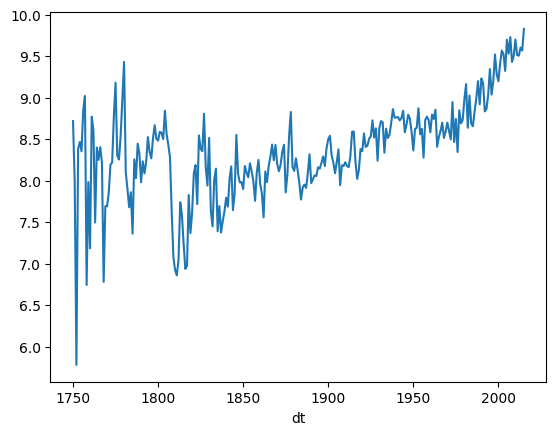

In [10]:
# convert dt column to datetime
data['dt'] = pd.to_datetime(data['dt'])

# plot the data['LandAverageTemperature], group by year
data.groupby(data['dt'].dt.year)['LandAverageTemperature'].mean().plot()
plt.show()

### Data Cleaning

1. Data from `1800-01-01` (inclusive) to `2015-12-01` (inclusive)
2. Train data from `1800-01-01` to `1999-12-01`
    * Training set from `1800-01-01` to `1959-12-01`
    * Validation set from `1960-01-01` to `1999-12-01`
3. Test data from `2000-01-01` to `2015-12-01`

In [11]:
# convert dt column from str to datetime
data['dt'] = pd.to_datetime(data['dt'])

# keep first 2 columns
data = data.iloc[:, :2]

# split into train, validation and test sets
train_data = data[(data['dt'] >= '1800-01-01') & (data['dt'] < '1960-01-01')]
validation_data = data[(data['dt'] >= '1960-01-01') & (data['dt'] < '2000-01-01')]
test_data = data[(data['dt'] >= '2000-01-01')] 

# check shapes, check first and last column of each set
print(f'train_data shape: {train_data.shape}')
# print(f'train_data first row: {train_data.iloc[0, :]}')
# print(f'train_data last row: {train_data.iloc[-1, :]}\n')

print(f'validation_data shape: {validation_data.shape}')
# print(f'validation_data first row: {validation_data.iloc[0, :]}')
# print(f'validation_data last row: {validation_data.iloc[-1, :]}\n')

print(f'test_data shape: {test_data.shape}')
# print(f'test_data first row: {test_data.iloc[0, :]}')
# print(f'test_data last row: {test_data.iloc[-1, :]}\n')

train_data shape: (1920, 2)
validation_data shape: (480, 2)
test_data shape: (192, 2)


In [12]:
# generate sequences
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset.iloc[i:i+lookback, 1]
        target = dataset.iloc[i+1:i+lookback+1, 1]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

In [18]:
# generate sequences
def create_validation_test_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset.iloc[i:i+lookback, 1]
        target = dataset.iloc[i+lookback, 1]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

In [13]:
train_X, train_y = create_dataset(train_data, 12)

# print shape
print(f'train_X shape: {train_X.shape}')
print(f'train_y shape: {train_y.shape}')

train_X shape: (1908, 12)
train_y shape: (1908, 12)


In [19]:
validate_X, validate_y = create_validation_test_dataset(validation_data, 12)

# print shape
print(f'validate_X shape: {validate_X.shape}')
print(f'validate_y shape: {validate_y.shape}')

validate_X shape: (468, 12)
validate_y shape: (468,)


In [21]:
test_X, test_y = create_validation_test_dataset(test_data, 12)

# print shape
print(f'test_X shape: {test_X.shape}')
print(f'test_y shape: {test_y.shape}')

test_X shape: (180, 12)
test_y shape: (180,)


In [14]:
train_X[0].shape

(12,)

### Set Up LSTM Parameters

In [47]:
# parameters
N = train_X.shape[0]
batch_size = 1 # B
input_size = 1 # F
hidden_size = 100 # U
sequence_length = 12 # L
output_size = 1 # O

# generate weights from LSTM model
model = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
W_ih = model.weight_ih_l0.detach().numpy().T
W_hh = model.weight_hh_l0.detach().numpy().T
b = model.bias_ih_l0.detach().numpy().T + model.bias_hh_l0.detach().numpy().T
#W_ih = np.random.normal(0, 1, size=(input_size, 4*hidden_size)) # dim = (F, 4U)
#W_hh = np.random.normal(0, 1, size=(hidden_size, 4*hidden_size)) # dim = (U, 4U)
#b = np.random.normal(0, 1, size=(1, 4*hidden_size)) # dim = (1, 4U)

# generate weights for the output layer
W_out = np.random.normal(0, 1, size=(hidden_size, output_size)) # dim = (U, O)
b_out = np.random.normal(0, 1, size=(1, output_size)) # dim = (1, O)

# initial hidden and cell states and params
h0_init = np.random.randn(1, batch_size, hidden_size).astype(np.float32) # dim = (B, U)
c0_init = np.random.randn(1, batch_size, hidden_size).astype(np.float32) # dim = (B, U)
params_init = [W_ih, W_hh, b, W_out, b_out]

# print all the shapes
print(f'W_ih shape: {W_ih.shape}')
print(f'W_hh shape: {W_hh.shape}')
print(f'b shape: {b.shape}')
print(f'W_out shape: {W_out.shape}')
print(f'b_out shape: {b_out.shape}')
print(f'h0_init shape: {h0_init.shape}')
print(f'c0_init shape: {c0_init.shape}')

W_ih shape: (1, 400)
W_hh shape: (100, 400)
b shape: (400,)
W_out shape: (100, 1)
b_out shape: (1, 1)
h0_init shape: (1, 1, 100)
c0_init shape: (1, 1, 100)


### Model Training

#### Gradient Descent

In [57]:
# perform training
lr = 0.001

# store losses
train_losses = []
validation_losses = []
test_losses = []

# initial hidden and cell states
params = params_init.copy()
h0 = h0_init.copy()
c0 = c0_init.copy()

# train the model
for i in range(N):
    # start timing
    start = time.time()

    # extract input and output from train_X and train_y
    # train_X dim = (N, L, F), x[i] dim = (L, F) but we need (L, B, F)
    x = train_X[i].reshape(sequence_length, batch_size, input_size)
    # train_y dim = (N, L, 0), y[i] dim = (L, 0) but we need (L*B, 0)
    y = train_y[i].reshape(sequence_length*batch_size, output_size)    

    # calculate the loss
    train_loss = loss(params, x, y, h0[0], c0[0])
    train_losses.append(train_loss)

    # update the parameters
    params = update(params, x, y, h0[0], c0[0])
    
    # end timing
    end = time.time()

    # print the loss and time taken
    if i % 100 == 0:
        print(f'Iter {i+1}/{N} \tLoss: {train_loss} \tTime: {end-start}')

Iter 1/1908 	Loss: 64.36351776123047 	Time: 0.022202014923095703
Iter 101/1908 	Loss: 20.491588592529297 	Time: 0.0004191398620605469
Iter 201/1908 	Loss: 6.84968900680542 	Time: 0.0003590583801269531
Iter 301/1908 	Loss: 10.42642593383789 	Time: 0.00035881996154785156
Iter 401/1908 	Loss: 12.834165573120117 	Time: 0.0003478527069091797
Iter 501/1908 	Loss: 7.451882839202881 	Time: 0.00035119056701660156
Iter 601/1908 	Loss: 8.706022262573242 	Time: 0.00041604042053222656
Iter 701/1908 	Loss: 9.41305923461914 	Time: 0.0003910064697265625
Iter 801/1908 	Loss: 7.363777160644531 	Time: 0.0008218288421630859
Iter 901/1908 	Loss: 7.981547832489014 	Time: 0.0006251335144042969
Iter 1001/1908 	Loss: 7.55429744720459 	Time: 0.0005943775177001953
Iter 1101/1908 	Loss: 7.69019889831543 	Time: 0.0003986358642578125
Iter 1201/1908 	Loss: 6.037693977355957 	Time: 0.0006251335144042969
Iter 1301/1908 	Loss: 7.041480541229248 	Time: 0.0003902912139892578
Iter 1401/1908 	Loss: 8.134048461914062 	Time:

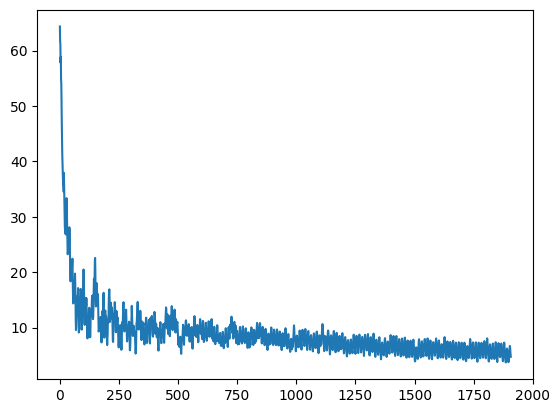

In [54]:
# plot loss
plt.plot(train_losses)
plt.show()

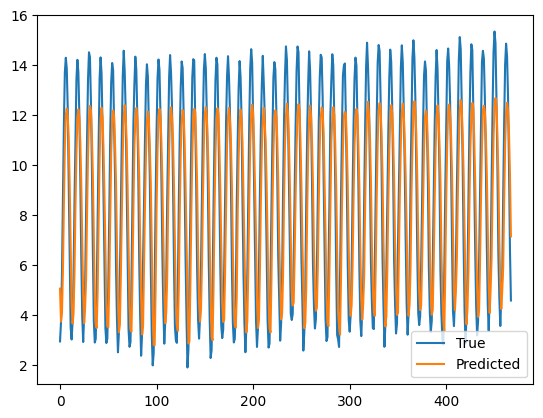

In [55]:
# generate predictions
def predict(params, X, h0, c0):
    y_pred = LSTMModel(params, X, h0, c0)
    return y_pred # dim = (B*L, O)

# generate predictions on validation set
# reshape like --> x = train_X[i].reshape(sequence_length, batch_size, input_size)
V = len(validate_X)
v_y_true = validate_y
v_y_preds = []
for i in range(V):
    x = validate_X[i].reshape(sequence_length, batch_size, input_size)
    # here, only the last element is needed
    v_y_pred = predict(params, x, h0[0], c0[0])
    v_y_preds.append(v_y_pred[-1])

# convert to numpy array
v_y_preds = np.array(v_y_preds)

# plot the predictions against actual, predicted values as red, original as blue
plt.plot(v_y_true, label='True')
plt.plot(v_y_preds, label='Predicted')
plt.legend()
plt.show()

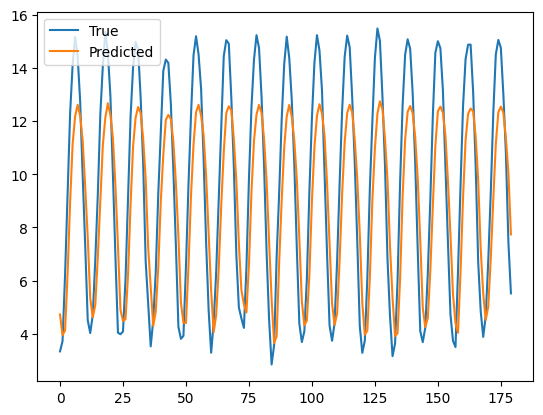

In [56]:
# predict on test set
T = len(test_X)
y_true = test_y
y_preds = []
for i in range(T):
    x = test_X[i].reshape(sequence_length, batch_size, input_size)
    # here, only the last element is needed
    y_pred = predict(params, x, h0[0], c0[0])
    y_preds.append(y_pred[-1])

# convert to numpy array
y_preds = np.array(y_preds)

# plot the predictions against actual, predicted values as red, original as blue
plt.plot(y_true, label='True')
plt.plot(y_preds, label='Predicted')
plt.legend()
plt.show()